In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import glob
import sys
import pandasql as pdsql

sys.path.append("..")
import analysislib as alib

In [3]:
sq = lambda q: pdsql.sqldf(q, globals())
sqflat = lambda q: alib.flatten(pdsql.sqldf(q, globals()).values.tolist())

In [4]:
compressionAlg = pd.read_csv("../../data/2025-03-27-time-14-19-14-fourth-run-compression-alg/master.csv", index_col=0)
dumps = pd.read_csv("../../data/2025-03-27-time-21-09-14-fourth-run-dumps/master.csv", index_col=0)
compressionRatio = pd.read_csv("../../data/2025-03-28-time-12-00-50-fourth-run-compression-ratio/master.csv", index_col=0)

# Compression algorithm (on fio's random data)

In [5]:
compressionAlg.columns

Index(['cbSize', 'cioengine', 'ciodepth', 'crw', 'cnproc', 'cdevice',
       'cdirect', 'cmemlim', 'cfile', 'readBW_bytes', 'readBW',
       'writeBW_bytes', 'writeBW', 'avgreadlat_ns', 'avgreadlat',
       'avgwritelat_ns', 'avgwritelat', 'USR_UTIL_perc', 'SYS_UTIL_perc',
       'IOW_UTIL_perc', 'IDL_UTIL_perc', 'CPU_UTIL_perc'],
      dtype='object')

In [6]:
sq("""
    SELECT cdevice, crw, readBW, writeBW
    FROM compressionAlg
    WHERE cioengine="mmap"
""")

,cdevice,crw,readBW,writeBW
0,ssd,randread,2.6 GB,0.0 B
1,zram-lzo,randread,14.0 GB,0.0 B
2,zram-zstd,randread,13.6 GB,0.0 B
3,zram-lz4,randread,13.2 GB,0.0 B
4,ssd,randrw,787.6 MB,787.3 MB
5,zram-lzo,randrw,1.8 GB,1.8 GB
6,zram-zstd,randrw,1.3 GB,1.3 GB
7,zram-lz4,randrw,2.0 GB,2.0 GB
8,ssd,randwrite,0.0 B,1.2 GB
9,zram-lzo,randwrite,0.0 B,2.0 GB


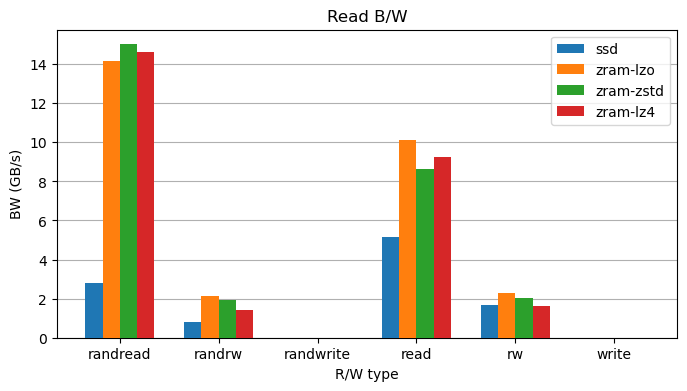

In [9]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT crw FROM compressionAlg"),
    np.array(sqflat("SELECT readBW_bytes FROM compressionAlg WHERE cioengine='mmap' ORDER BY cdevice"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM compressionAlg"),
    title="Read B/W",
    ylabel="BW (GB/s)",
    xlabel="R/W type",
    show=False
)
plt.savefig("../../processed-data/2025-03-28-heapdump/compAlg-randomdata-read.png")

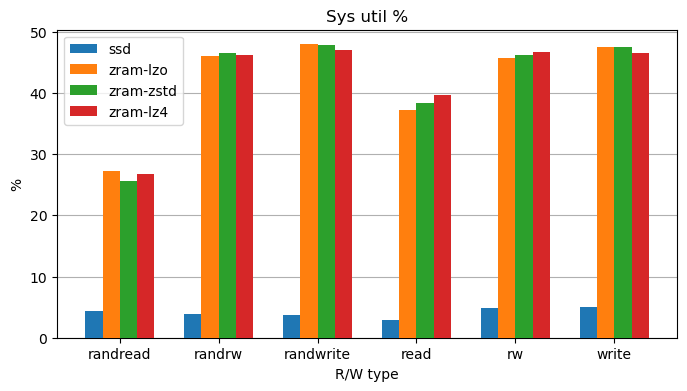

In [11]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT crw FROM compressionAlg"),
    sqflat("SELECT SYS_UTIL_perc FROM compressionAlg WHERE cioengine='mmap' ORDER BY cdevice"),
    labels=sqflat("SELECT DISTINCT cdevice FROM compressionAlg"),
    title="Sys util %",
    ylabel="%",
    xlabel="R/W type",
    show=False
)
plt.savefig("../../processed-data/2025-03-28-heapdump/compAlg-randomdata-sysutil.png")

# Compression ratio (on heap dumps)

In [24]:
dumpsizes = pd.read_csv("../../dumpsizes", sep="\s+", header=None, names=["size", "filename"])
dumpsizes["dumpname"] = dumpsizes["filename"].apply(lambda s: s.split("/")[1].split(".")[0].split("-")[0])
dumpsizes["dumpID"] = dumpsizes["filename"].apply(lambda s: s.split("/")[1].split(".")[0])

dumpsizes["size_bytes"] = dumpsizes["size"].apply(alib.unformat_size_1)

dumpsizesGB = sq("SELECT dumpname, AVG(size_bytes)/1000000000 as size_GB FROM dumpsizes GROUP BY dumpname ORDER BY size_GB DESC")
dumpsizesGB


,dumpname,size_GB
0,h2,8.938937
1,pmd,5.476083
2,batik,4.119003
3,biojava,2.040109
4,graphchi,1.267109
5,h2o,0.928403
6,tradebeans,0.746154
7,tradesoap,0.330116
8,kafka,0.316495
9,spring,0.243869


In [28]:
compressionRatio.columns

Index(['benchmark', 'dumpNo', 'compression_alg', 'data_bytes',
       'compressed_bytes', 'total_bytes', 'compr_ratio'],
      dtype='object')

In [13]:
sq("""
    SELECT compression_alg, AVG(compr_ratio) 
    FROM compressionRatio 
    WHERE compr_ratio > 0
    GROUP BY compression_alg
""")

,compression_alg,AVG(compr_ratio)
0,lz4,2.741956
1,lzo,3.398771
2,zstd,4.678152


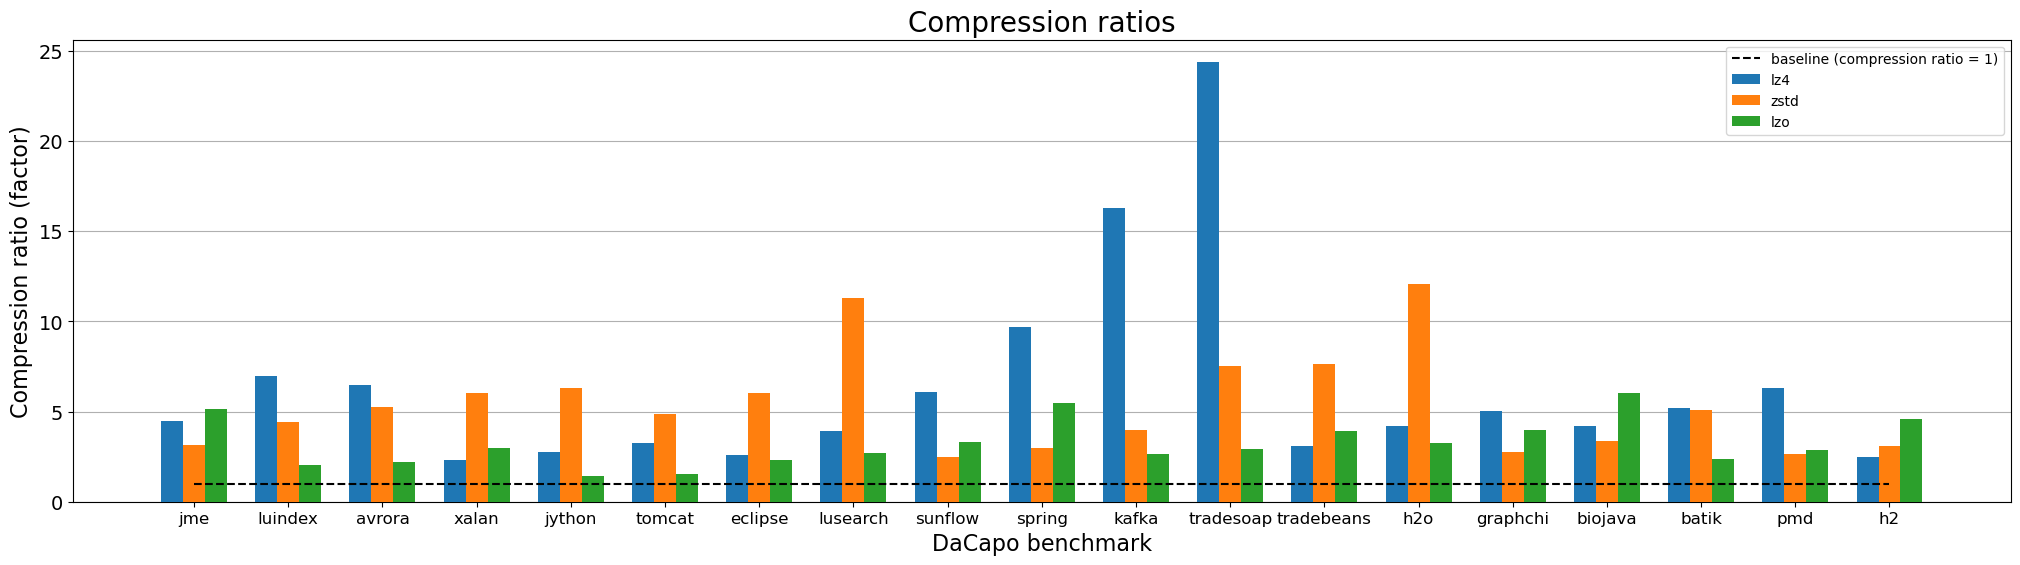

In [26]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT dumpname FROM dumpsizesGB ORDER BY size_GB"),
    sqflat("SELECT AVG(compr_ratio) FROM compressionRatio AS cr INNER JOIN dumpsizesGB AS ds ON cr.benchmark = ds.dumpname WHERE compr_ratio > 0 GROUP BY benchmark, compression_alg ORDER BY ds.size_GB"),
    labels=sqflat("SELECT DISTINCT compression_alg FROM compressionRatio"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Compression ratio (factor)",
    title="Compression ratios",
    show=False
)
nb = len(sqflat("SELECT DISTINCT benchmark FROM compressionRatio"))
plt.plot(range(nb), np.ones(nb), linestyle='--', zorder=100, color="#000000", label="baseline (compression ratio = 1)") # draw a line at 1 for baseline purposes

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.legend()

plt.savefig("../../processed-data/2025-03-28-heapdump/compratios.png")
plt.show()

# Compression algorithms (on heap dumps)

In [78]:
dumps.columns

Index(['cbSize', 'cioengine', 'ciodepth', 'crw', 'cnproc', 'cdevice',
       'cdirect', 'cmemlim', 'cdumpbc', 'cdumpno', 'cfile', 'readBW_bytes',
       'readBW', 'writeBW_bytes', 'writeBW', 'avgreadlat_ns', 'avgreadlat',
       'avgwritelat_ns', 'avgwritelat', 'USR_UTIL_perc', 'SYS_UTIL_perc',
       'IOW_UTIL_perc', 'IDL_UTIL_perc', 'CPU_UTIL_perc'],
      dtype='object')

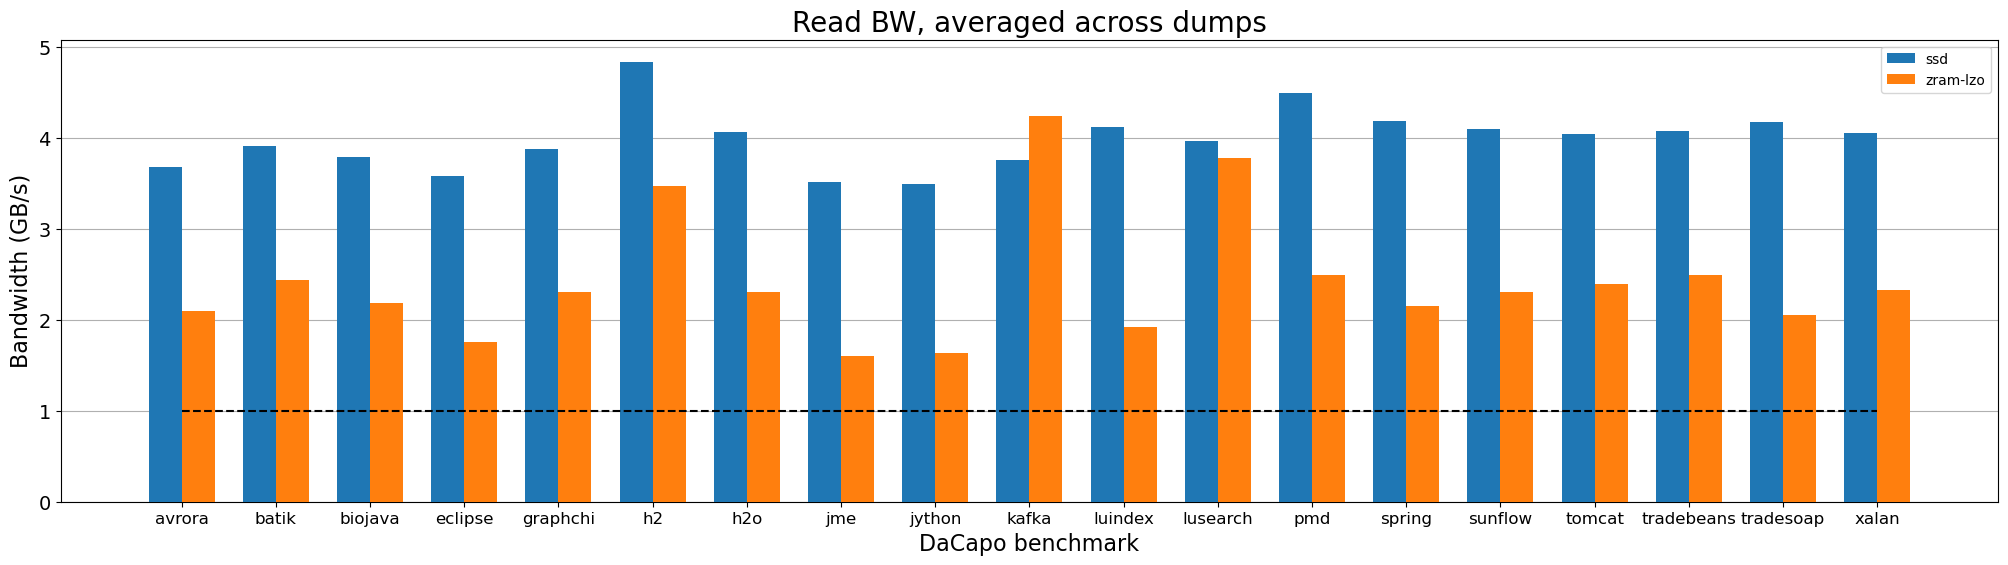

In [149]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cdumpbc FROM dumps"),
    np.array(sqflat("SELECT AVG(readBW_bytes) FROM dumps WHERE crw='read' AND cdevice!='zram-zstd' GROUP BY cdevice, cdumpbc"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Bandwidth (GB/s)",
    title="Read BW, averaged across dumps",
    show=False
)
nb = len(sqflat("SELECT DISTINCT benchmark FROM compressionRatio"))
plt.plot(range(nb), np.ones(nb), linestyle='--', zorder=100, color="#000000") # draw a line at 1 for baseline purposes

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.show()

In [153]:
sq("""
    SELECT cdumpbc, cdevice, AVG(d.readBW_bytes) 
    FROM dumps AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname
    WHERE d.crw='read' AND d.cdevice !='zram-zstd'
    GROUP BY cdumpbc, cdevice
    ORDER BY ds.size_GB DESC
""")
print("suppress output")

suppress output


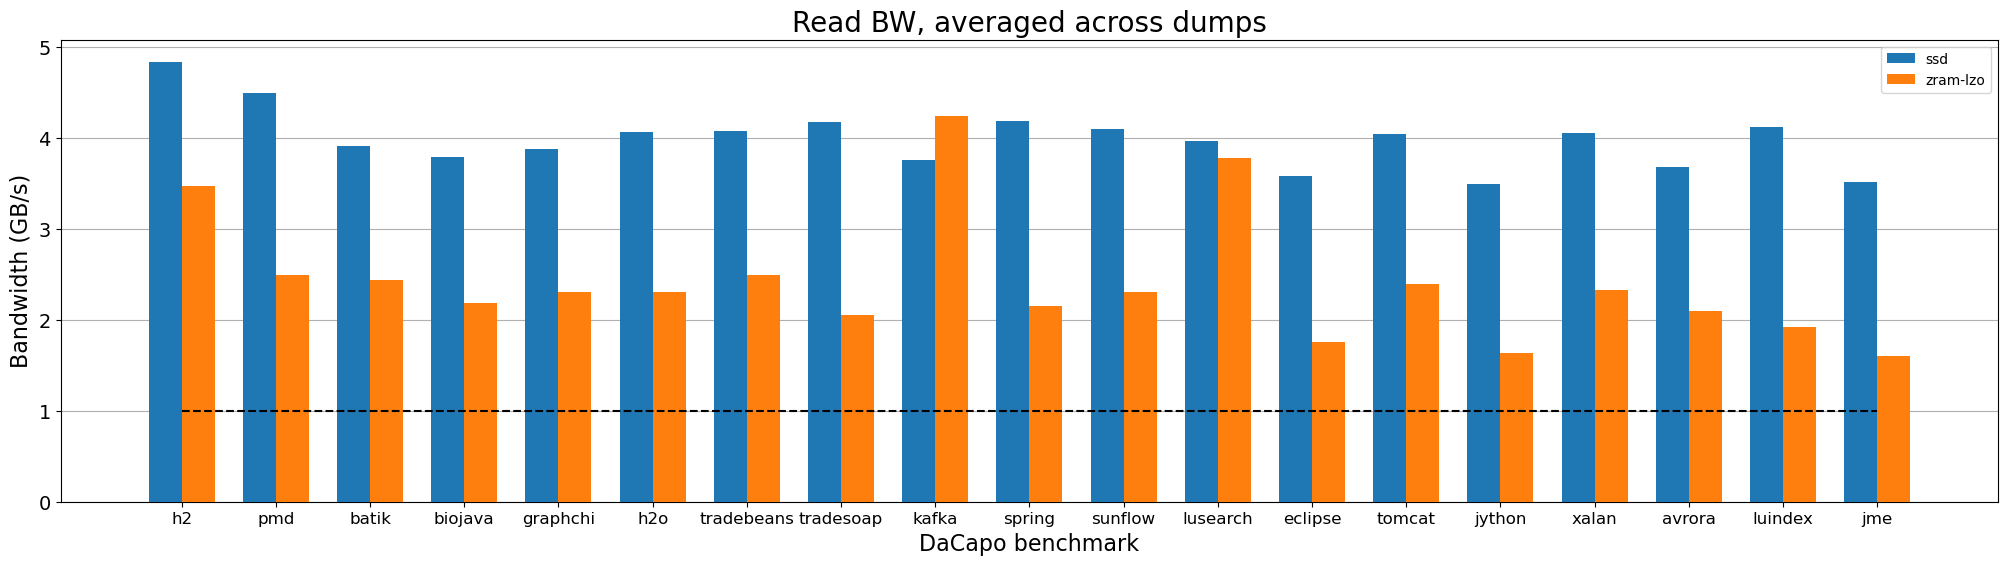

In [152]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    np.array(sqflat("SELECT AVG(d.readBW_bytes) FROM dumps AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' AND d.cdevice !='zram-zstd' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Bandwidth (GB/s)",
    title="Read BW, averaged across dumps",
    show=False
)
nb = len(sqflat("SELECT DISTINCT benchmark FROM compressionRatio"))
plt.plot(range(nb), np.ones(nb), linestyle='--', zorder=100, color="#000000") # draw a line at 1 for baseline purposes

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.show()

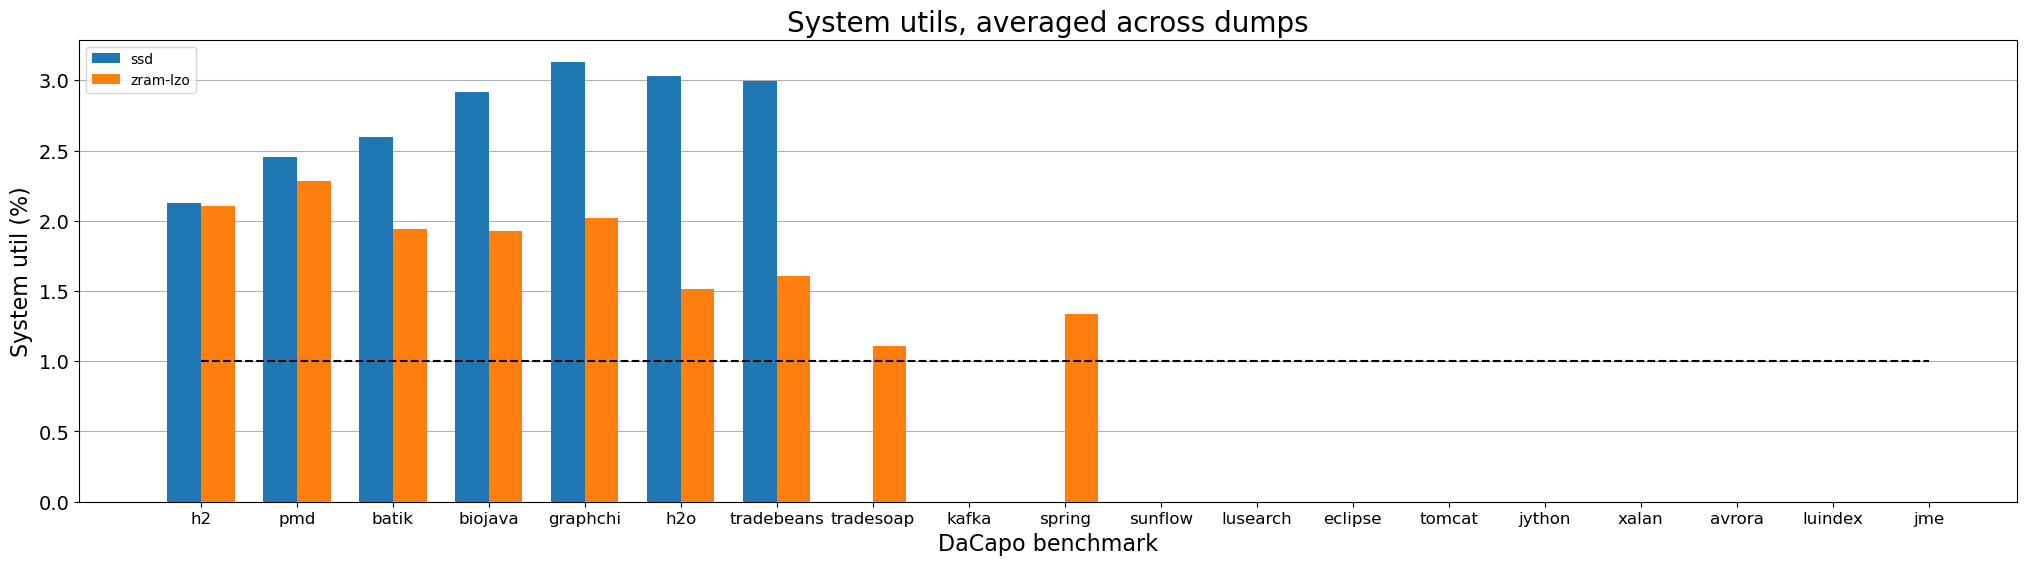

In [155]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.SYS_UTIL_perc) FROM dumps AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' AND d.cdevice !='zram-zstd' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="System util (%)",
    title="System utils, averaged across dumps",
    show=False
)
nb = len(sqflat("SELECT DISTINCT benchmark FROM compressionRatio"))
plt.plot(range(nb), np.ones(nb), linestyle='--', zorder=100, color="#000000") # draw a line at 1 for baseline purposes

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.show()

i have a feeling we are observing this because i put the number of processes down to 8 whoops lol
- I'll try 32 again and check to make sure